# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Baseline, nothing exluded.

Like MLP_243 but use GMM threshold.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 18:34:07.618277


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_260'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 18:34:48.077863
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 18:34:48.477102
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-09 18:34:59.867075
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-09 18:35:00.535048
Discriminator is GMM
Means [-0.12353649167716341, -2.7492144436660695]
Variances [1.50711037 1.99461298]
Priors [0.57052389 0.42947611]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2091:1405 59.81%
Valid 1:0 508:367 58.06%
FIT
2023-04-09 18:35:01.860681


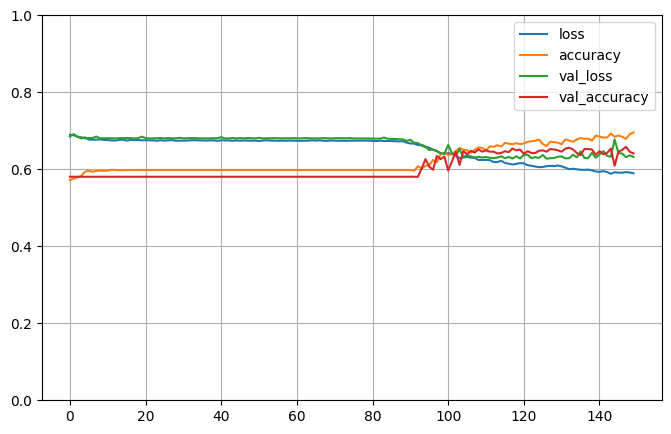


Testing # 1 1
2023-04-09 18:36:37.168476
2023-04-09 18:36:37.168861
PREDICT
2023-04-09 18:36:37.180580
Test 1:0 508:367 58.06%
Predict 1:0 638:237 72.91%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.604804 mean 0.18191871 std
Range of scores: 0.05871415 to 0.9301171
Score threshold 0.5
Confusion matrix
 [[145 222]
 [ 92 416]]
Normalized matrix
 [[0.16571429 0.25371429]
 [0.10514286 0.47542857]]
Extreme scores correct, pos:neg 287 62
Extreme scores incorrect pos:neg 111 25


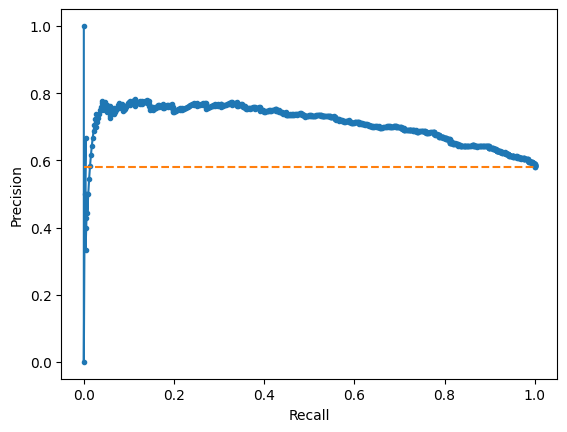

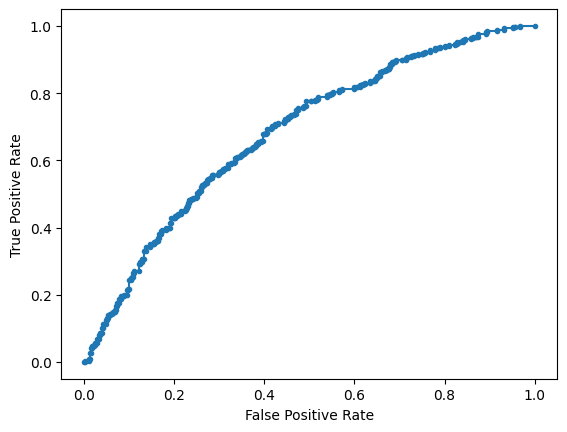

Accuracy: 64.11% Precision: 65.20% Recall: 81.89%
F1: 72.60% MCC: 0.2376
AUPRC: 71.04% AUROC: 68.13%
 accuracy [64.11428571428571]
 precision [65.20376175548589]
 recall [81.88976377952756]
 F1 [72.6003490401396]
 MCC [0.23761833835801294]
 AUPRC [71.03940524501088]
 AUROC [68.1322276813491]

Training # 1 2
2023-04-09 18:36:38.221559
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-09 18:36:38.917513
Discriminator is GMM
Means [-2.755657665223357, -0.15507654504140742]
Variances [2.06354601 1.42953516]
Priors [0.432784 0.567216]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2091:1405 59.81%
Valid 1:0 516:359 58.97%
FIT
2023-04-09 18:36:40.209388


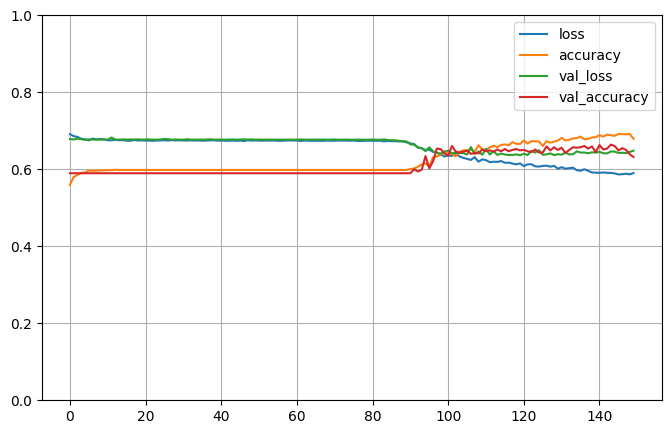


Testing # 1 2
2023-04-09 18:38:16.418704
2023-04-09 18:38:16.422386
PREDICT
2023-04-09 18:38:16.427609
Test 1:0 516:359 58.97%
Predict 1:0 534:341 61.03%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.54815626 mean 0.18754241 std
Range of scores: 0.044606272 to 0.9611493
Score threshold 0.5
Confusion matrix
 [[189 170]
 [152 364]]
Normalized matrix
 [[0.216      0.19428571]
 [0.17371429 0.416     ]]
Extreme scores correct, pos:neg 202 98
Extreme scores incorrect pos:neg 79 39


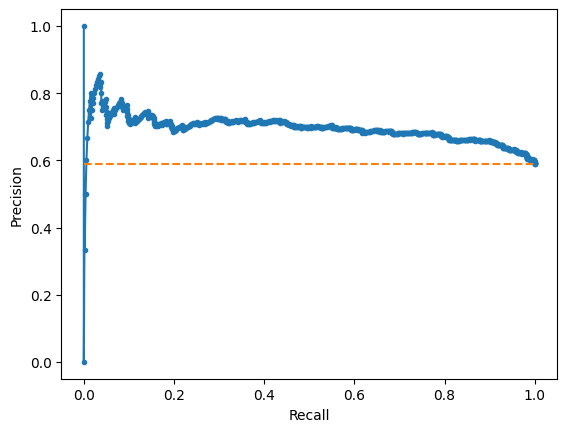

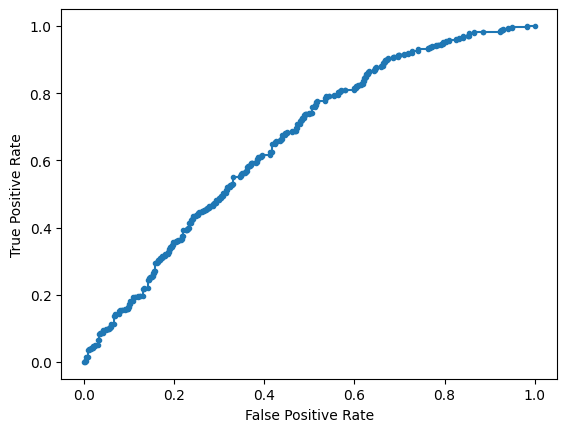

Accuracy: 63.20% Precision: 68.16% Recall: 70.54%
F1: 69.33% MCC: 0.2339
AUPRC: 69.47% AUROC: 65.67%
 accuracy [63.2]
 precision [68.16479400749064]
 recall [70.54263565891473]
 F1 [69.33333333333334]
 MCC [0.23388584603136003]
 AUPRC [69.46965208244794]
 AUROC [65.67068299108205]

Training # 1 3
2023-04-09 18:38:17.688794
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-09 18:38:18.384478
Discriminator is GMM
Means [-0.10647496210854544, -2.781995929410141]
Variances [1.49864906 2.0823436 ]
Priors [0.57174195 0.42825805]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2095:1402 59.91%
Valid 1:0 510:364 58.35%
FIT
2023-04-09 18:38:19.500548


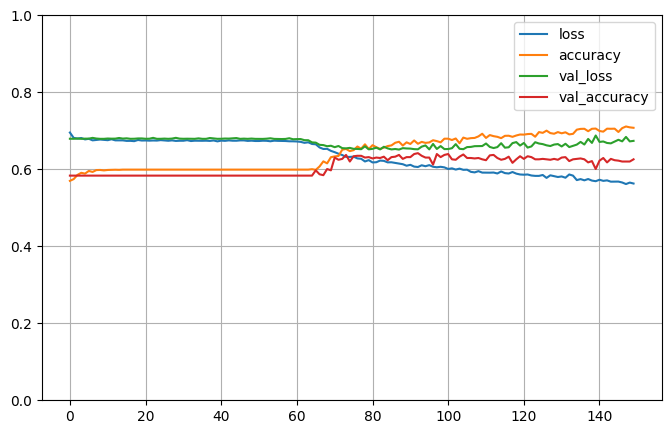


Testing # 1 3
2023-04-09 18:39:53.513167
2023-04-09 18:39:53.513661
PREDICT
2023-04-09 18:39:53.522061
Test 1:0 510:364 58.35%
Predict 1:0 583:291 66.70%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5807607 mean 0.20282216 std
Range of scores: 0.04955502 to 0.95959383
Score threshold 0.5
Confusion matrix
 [[164 200]
 [127 383]]
Normalized matrix
 [[0.18764302 0.22883295]
 [0.14530892 0.4382151 ]]
Extreme scores correct, pos:neg 252 78
Extreme scores incorrect pos:neg 110 50


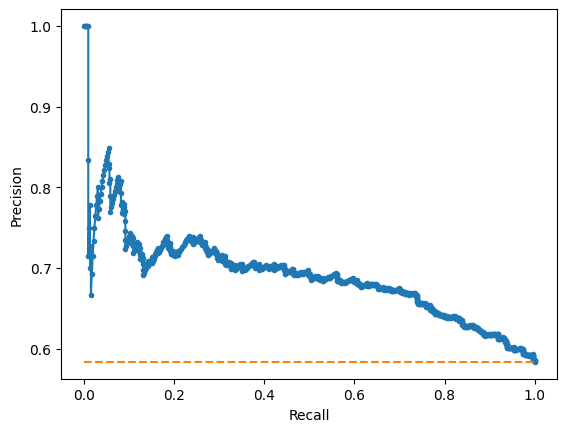

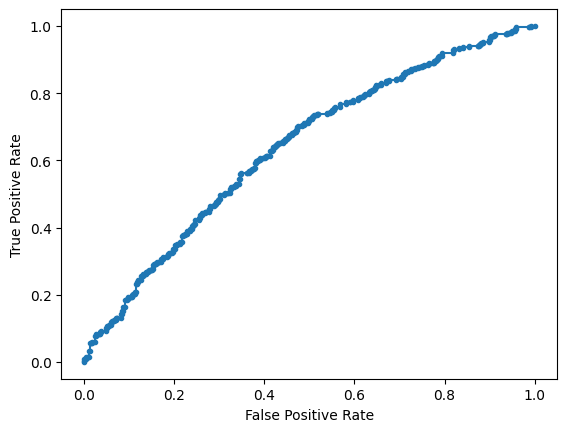

Accuracy: 62.59% Precision: 65.69% Recall: 75.10%
F1: 70.08% MCC: 0.2108
AUPRC: 69.02% AUROC: 63.70%
 accuracy [62.58581235697941]
 precision [65.69468267581475]
 recall [75.09803921568627]
 F1 [70.08234217749315]
 MCC [0.21081153664729435]
 AUPRC [69.0240276622713]
 AUROC [63.701788407670755]

Training # 1 4
2023-04-09 18:39:54.380886
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-09 18:39:55.068367
Discriminator is GMM
Means [-0.10819901877560015, -2.7618271525964446]
Variances [1.47141094 1.96087741]
Priors [0.5591907 0.4408093]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2025:1472 57.91%
Valid 1:0 532:342 60.87%
FIT
2023-04-09 18:39:57.032643


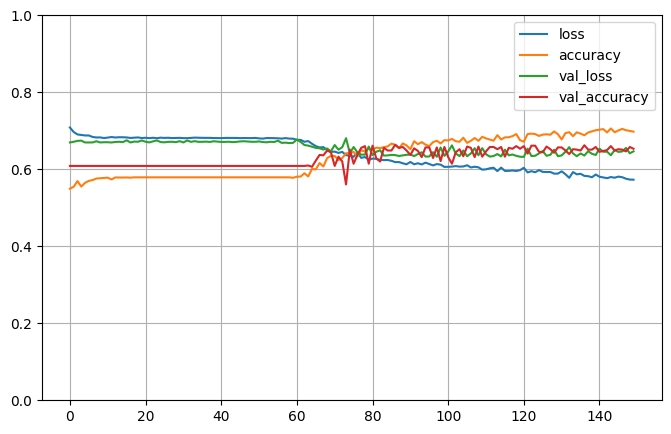


Testing # 1 4
2023-04-09 18:41:30.863097
2023-04-09 18:41:30.863173
PREDICT
2023-04-09 18:41:30.874452
Test 1:0 532:342 60.87%
Predict 1:0 587:287 67.16%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.56974864 mean 0.20626557 std
Range of scores: 0.0038924278 to 0.9016155
Score threshold 0.5
Confusion matrix
 [[163 179]
 [124 408]]
Normalized matrix
 [[0.18649886 0.20480549]
 [0.14187643 0.46681922]]
Extreme scores correct, pos:neg 273 93
Extreme scores incorrect pos:neg 94 52


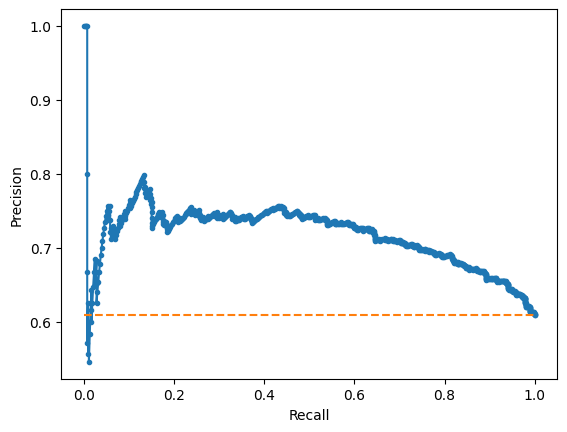

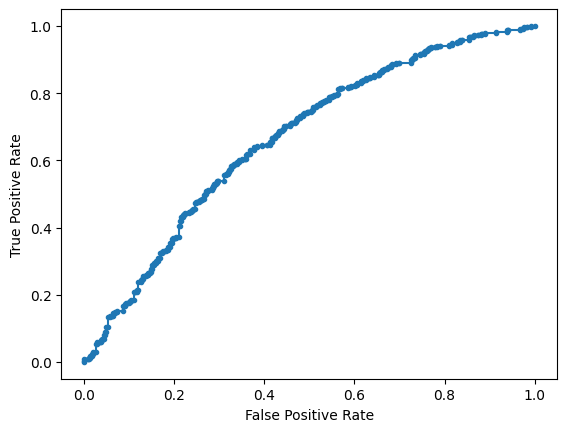

Accuracy: 65.33% Precision: 69.51% Recall: 76.69%
F1: 72.92% MCC: 0.2531
AUPRC: 71.77% AUROC: 66.49%
 accuracy [65.33180778032036]
 precision [69.50596252129472]
 recall [76.69172932330827]
 F1 [72.92225201072387]
 MCC [0.25307735035340423]
 AUPRC [71.77278459676954]
 AUROC [66.49353647276087]

Training # 1 5
2023-04-09 18:41:31.830443
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-09 18:41:32.532022
Discriminator is GMM
Means [-0.16130573241105356, -2.803926567717419]
Variances [1.51780467 2.06827944]
Priors [0.57216584 0.42783416]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2095:1403 59.89%
Valid 1:0 540:333 61.86%
FIT
2023-04-09 18:41:35.018524


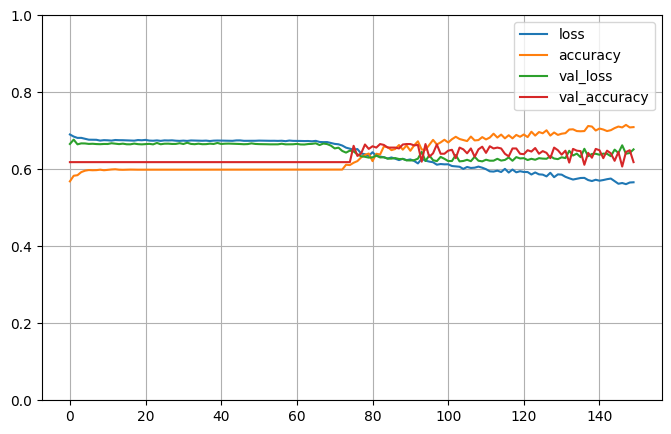


Testing # 1 5
2023-04-09 18:43:58.308158
2023-04-09 18:43:58.308246
PREDICT
2023-04-09 18:43:58.326495
Test 1:0 540:333 61.86%
Predict 1:0 533:340 61.05%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.5594025 mean 0.20879246 std
Range of scores: 0.050251015 to 0.969022
Score threshold 0.5
Confusion matrix
 [[170 163]
 [170 370]]
Normalized matrix
 [[0.19473081 0.18671249]
 [0.19473081 0.42382589]]
Extreme scores correct, pos:neg 233 89
Extreme scores incorrect pos:neg 77 66


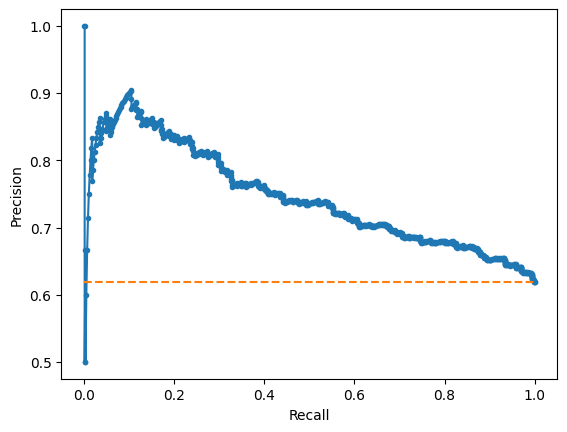

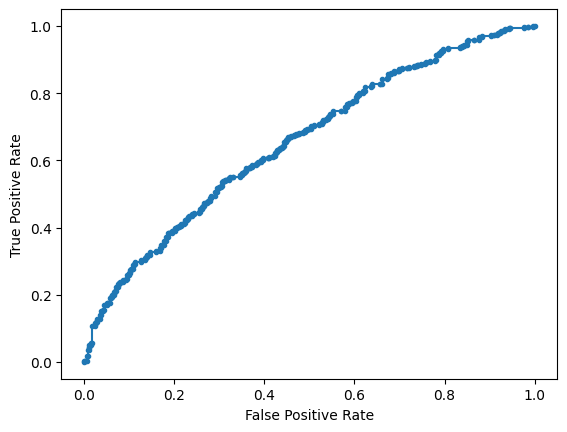

Accuracy: 61.86% Precision: 69.42% Recall: 68.52%
F1: 68.97% MCC: 0.1949
AUPRC: 74.47% AUROC: 65.41%
 accuracy [61.855670103092784]
 precision [69.41838649155723]
 recall [68.51851851851852]
 F1 [68.96551724137933]
 MCC [0.19493831469860382]
 AUPRC [74.47489073209505]
 AUROC [65.40596151707263]

Training # 2 1
2023-04-09 18:43:59.035542
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-09 18:43:59.790936
Discriminator is GMM
Means [-0.11372879952619407, -2.7425220412195874]
Variances [1.4819813 2.0539251]
Priors [0.56613822 0.43386178]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2086:1410 59.67%
Valid 1:0 503:372 57.49%
FIT
2023-04-09 18:44:03.717119


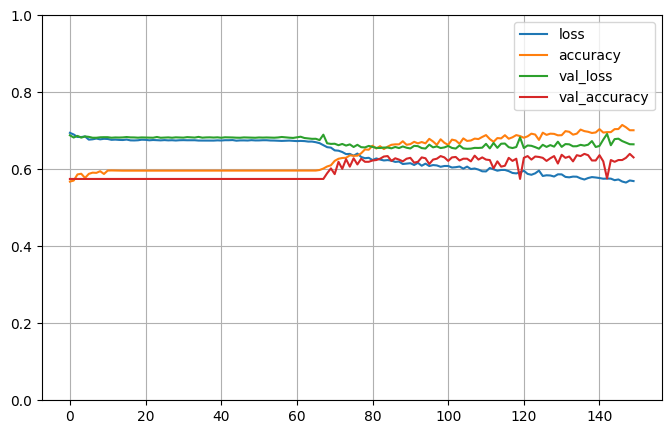


Testing # 2 1
2023-04-09 18:46:26.986188
2023-04-09 18:46:26.986244
PREDICT
2023-04-09 18:46:26.999520
Test 1:0 503:372 57.49%
Predict 1:0 624:251 71.31%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5958374 mean 0.1936418 std
Range of scores: 0.015109113 to 0.93701243
Score threshold 0.5
Confusion matrix
 [[150 222]
 [101 402]]
Normalized matrix
 [[0.17142857 0.25371429]
 [0.11542857 0.45942857]]
Extreme scores correct, pos:neg 255 75
Extreme scores incorrect pos:neg 128 32


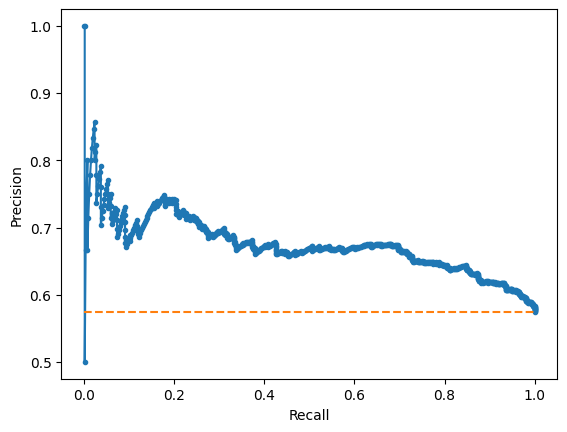

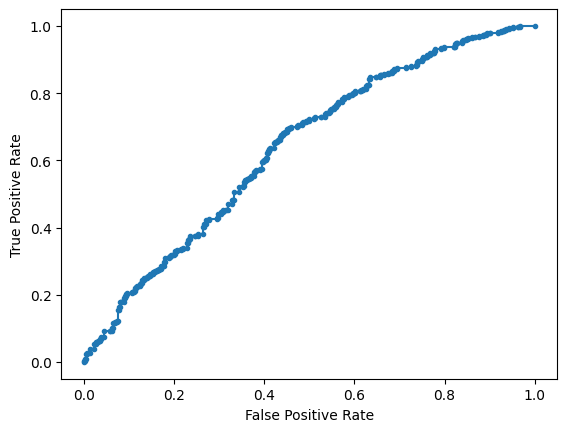

Accuracy: 63.09% Precision: 64.42% Recall: 79.92%
F1: 71.34% MCC: 0.2213
AUPRC: 67.45% AUROC: 63.79%
 accuracy [63.08571428571429]
 precision [64.42307692307693]
 recall [79.92047713717693]
 F1 [71.33984028393967]
 MCC [0.22125975219646254]
 AUPRC [67.44628871927105]
 AUROC [63.791979306953984]

Training # 2 2
2023-04-09 18:46:27.605783
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-09 18:46:28.507432
Discriminator is GMM
Means [-0.15734069380140106, -2.7912218978252654]
Variances [1.47408959 2.02749007]
Priors [0.57386612 0.42613388]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2107:1389 60.27%
Valid 1:0 525:350 60.00%
FIT
2023-04-09 18:46:31.729165


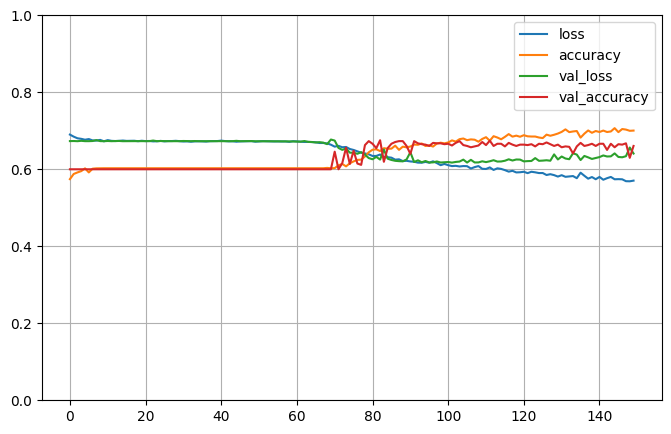


Testing # 2 2
2023-04-09 18:48:54.976932
2023-04-09 18:48:54.976982
PREDICT
2023-04-09 18:48:54.982619
Test 1:0 525:350 60.00%
Predict 1:0 702:173 80.23%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.66056305 mean 0.18673731 std
Range of scores: 0.06644827 to 0.9665035
Score threshold 0.5
Confusion matrix
 [[113 237]
 [ 60 465]]
Normalized matrix
 [[0.12914286 0.27085714]
 [0.06857143 0.53142857]]
Extreme scores correct, pos:neg 361 47
Extreme scores incorrect pos:neg 146 15


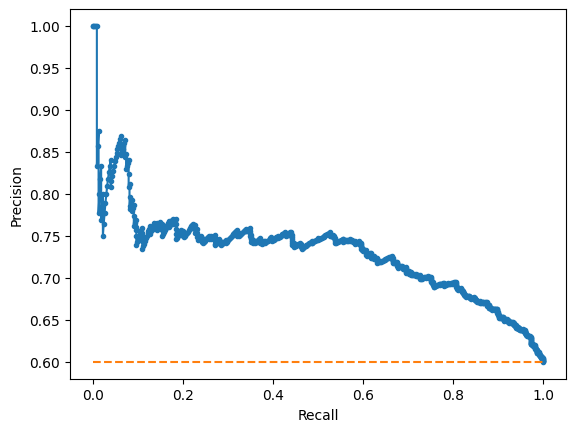

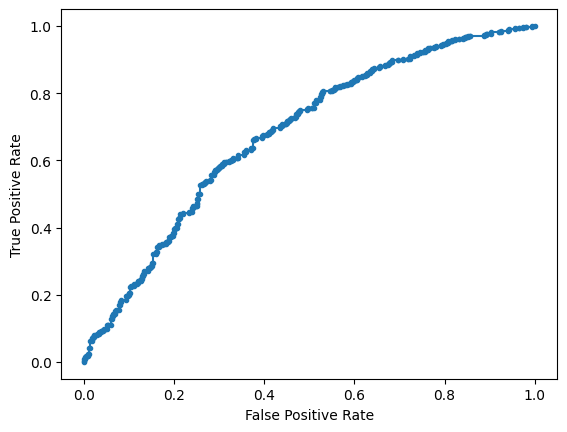

Accuracy: 66.06% Precision: 66.24% Recall: 88.57%
F1: 75.79% MCC: 0.2566
AUPRC: 73.06% AUROC: 67.88%
 accuracy [66.05714285714286]
 precision [66.23931623931624]
 recall [88.57142857142857]
 F1 [75.79462102689486]
 MCC [0.25655287274364735]
 AUPRC [73.06027230553617]
 AUROC [67.87918367346938]

Training # 2 3
2023-04-09 18:48:55.638372
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-09 18:48:57.317847
Discriminator is GMM
Means [-0.14175559866600776, -2.789900505796584]
Variances [1.46799439 2.01263245]
Priors [0.56461875 0.43538125]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2072:1425 59.25%
Valid 1:0 533:341 60.98%
FIT
2023-04-09 18:48:59.442766


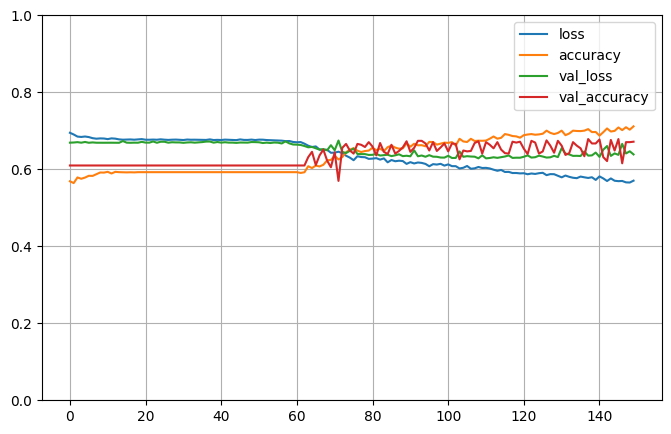


Testing # 2 3
2023-04-09 18:51:23.352330
2023-04-09 18:51:23.352377
PREDICT
2023-04-09 18:51:23.361009
Test 1:0 533:341 60.98%
Predict 1:0 668:206 76.43%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.63247883 mean 0.19932434 std
Range of scores: 0.04952456 to 0.9488625
Score threshold 0.5
Confusion matrix
 [[130 211]
 [ 76 457]]
Normalized matrix
 [[0.14874142 0.24141876]
 [0.08695652 0.5228833 ]]
Extreme scores correct, pos:neg 332 67
Extreme scores incorrect pos:neg 137 26


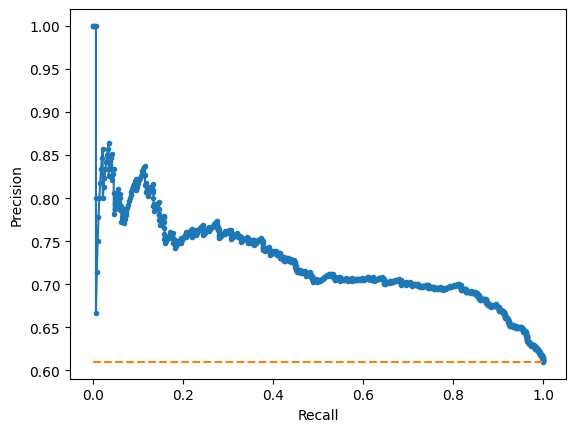

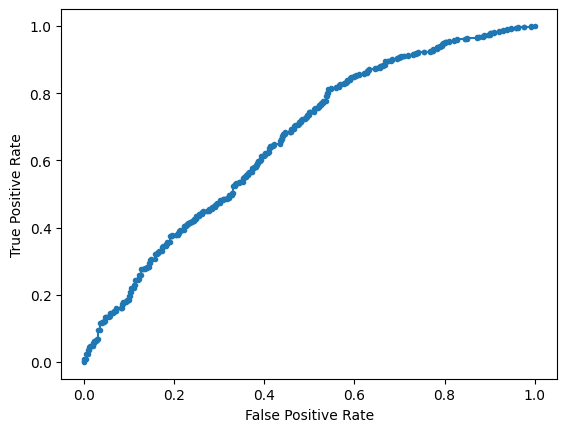

Accuracy: 67.16% Precision: 68.41% Recall: 85.74%
F1: 76.10% MCC: 0.2743
AUPRC: 72.75% AUROC: 66.12%
 accuracy [67.16247139588101]
 precision [68.41317365269461]
 recall [85.74108818011257]
 F1 [76.10324729392173]
 MCC [0.27426275845265763]
 AUPRC [72.75077250354165]
 AUROC [66.12380538423025]

Training # 2 4
2023-04-09 18:51:24.009622
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-09 18:51:24.689929
Discriminator is GMM
Means [-2.7775134423966796, -0.10928572591265324]
Variances [2.08879181 1.51554389]
Priors [0.42693146 0.57306854]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2103:1395 60.12%
Valid 1:0 506:367 57.96%
FIT
2023-04-09 18:51:28.400096


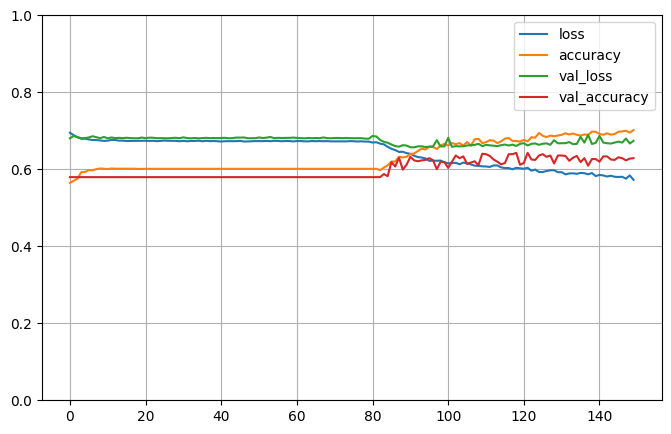


Testing # 2 4
2023-04-09 18:53:51.653949
2023-04-09 18:53:51.654010
PREDICT
2023-04-09 18:53:51.663529
Test 1:0 506:367 57.96%
Predict 1:0 606:267 69.42%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.58690566 mean 0.20564952 std
Range of scores: 0.030711899 to 0.9387547
Score threshold 0.5
Confusion matrix
 [[155 212]
 [112 394]]
Normalized matrix
 [[0.17754868 0.24284078]
 [0.12829324 0.4513173 ]]
Extreme scores correct, pos:neg 259 80
Extreme scores incorrect pos:neg 118 44


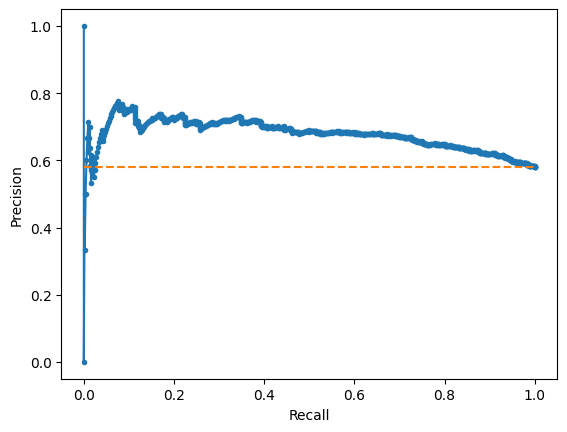

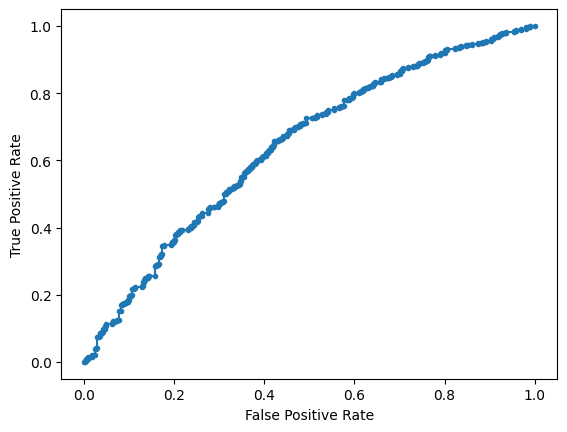

Accuracy: 62.89% Precision: 65.02% Recall: 77.87%
F1: 70.86% MCC: 0.2153
AUPRC: 67.73% AUROC: 64.12%
 accuracy [62.88659793814433]
 precision [65.01650165016501]
 recall [77.86561264822134]
 F1 [70.86330935251799]
 MCC [0.21533331109046053]
 AUPRC [67.73263997187316]
 AUROC [64.11724160213676]

Training # 2 5
2023-04-09 18:53:52.287375
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-09 18:53:53.953076
Discriminator is GMM
Means [-0.12175395649636286, -2.735796959325645]
Variances [1.47543451 1.99856448]
Priors [0.558142 0.441858]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2022:1475 57.82%
Valid 1:0 533:341 60.98%
FIT
2023-04-09 18:53:57.588382


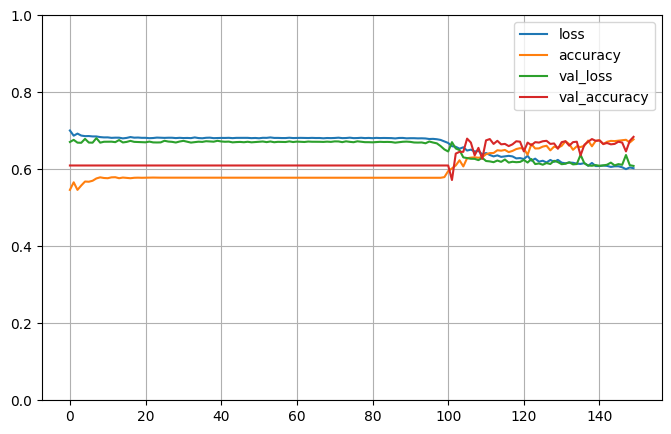


Testing # 2 5
2023-04-09 18:55:32.273064
2023-04-09 18:55:32.273467
PREDICT
2023-04-09 18:55:32.280609
Test 1:0 533:341 60.98%
Predict 1:0 643:231 73.57%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.599023 mean 0.16401525 std
Range of scores: 0.09470986 to 0.90295297
Score threshold 0.5
Confusion matrix
 [[148 193]
 [ 83 450]]
Normalized matrix
 [[0.16933638 0.2208238 ]
 [0.09496568 0.51487414]]
Extreme scores correct, pos:neg 271 49
Extreme scores incorrect pos:neg 77 22


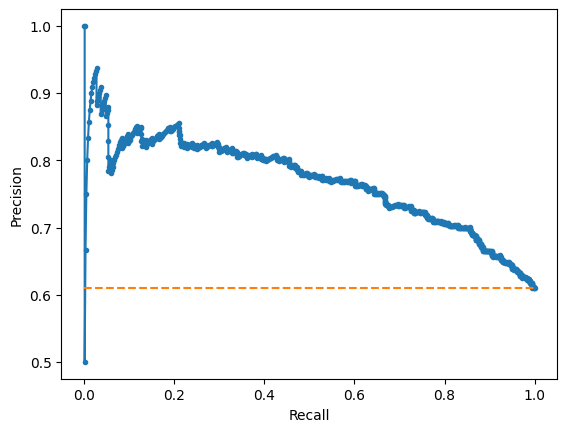

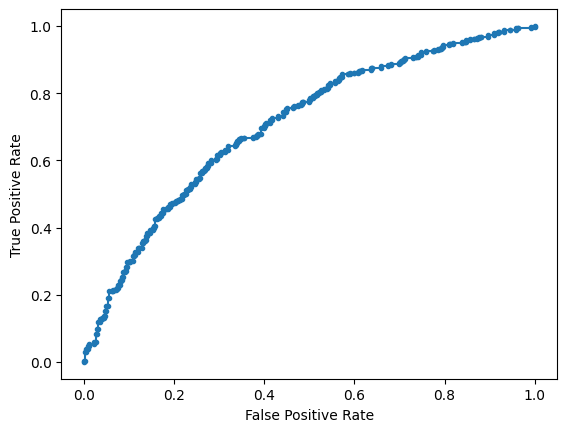

Accuracy: 68.42% Precision: 69.98% Recall: 84.43%
F1: 76.53% MCC: 0.3078
AUPRC: 76.85% AUROC: 70.57%
 accuracy [68.42105263157895]
 precision [69.98444790046656]
 recall [84.42776735459663]
 F1 [76.53061224489797]
 MCC [0.3078471524651303]
 AUPRC [76.84771106327969]
 AUROC [70.56554774886797]
2023-04-09 18:55:33.183701


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 64.47% std 2.18
 precision mean 67.21% std 2.11
 recall mean 78.93% std 6.49
 F1 mean 72.45% std 2.84
 MCC mean 0.2406 std 0.0335
 AUPRC mean 71.36% std 3.03
 AUROC mean 66.19% std 2.19
 accuracy [[64.11428571428571], [63.2], [62.58581235697941], [65.33180778032036], [61.855670103092784], [63.08571428571429], [66.05714285714286], [67.16247139588101], [62.88659793814433], [68.42105263157895]]
 precision [[65.20376175548589], [68.16479400749064], [65.69468267581475], [69.50596252129472], [69.41838649155723], [64.42307692307693], [66.23931623931624], [68.41317365269461], [65.01650165016501], [69.98444790046656]]
 recall [[81.88976377952756], [70.54263565891473], [75.09803921568627], [76.69172932330827], [68.51851851851852], [79.92047713717693], [88.57142857142857], [85.74108818011257], [77.86561264822134], [84.42776735459663]]
 F1 [[72.6003490401396], [69.33333333333334], [70.08234217749315], [72.92225201072387], [68.96551724137933], [71.33984028393967], [75.79462102689486]